In [77]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [78]:
# ----------------------------
# 1. 数据准备
# ----------------------------

#数据离散化修正
def discretize_features(X, medians):
    """正确离散化方法：对每个特征单独处理"""
    X_disc = np.zeros_like(X)
    for i in range(X.shape[1]):
        X_disc[:, i] = np.digitize(X[:, i], bins=[medians[i]])
    return X_disc

# 加载数据
iris = load_iris()
X, y = iris.data, iris.target
feature_names = iris.feature_names

# 计算训练集各特征中位数（用于ID3离散化）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
feature_medians = np.median(X_train, axis=0)
# 对训练/测试集进行正确的离散化处理
X_train_disc = discretize_features(X_train, feature_medians)
X_test_disc = discretize_features(X_test, feature_medians)

# 测试样本示例（离散化后）
test_sample = np.array([[5.1, 3.5, 1.4, 0.2]])
test_sample_disc = discretize_features(test_sample, feature_medians)


In [79]:
# ----------------------------
# 2. 模型训练（统一接口）
# ----------------------------
# 注意：Scikit-learn没有原生ID3/C4.5，需通过参数模拟
models = {
    # ID3模拟：使用信息增益 + 强制离散化（需预处理）
    "ID3": DecisionTreeClassifier(criterion='entropy', max_depth=5
                                  #min_impurity_decrease=0.01  # 信息增益需≥1%才分裂
                                  ),
    
    # C4.5模拟：使用信息增益 + 连续值自动处理（最接近C4.5效果）
    "C4.5": DecisionTreeClassifier(criterion='entropy', 
                                   max_depth=5
                                    #min_samples_split=20,        # 节点最少样本数才分裂
                                    #min_samples_leaf=10,         # 叶节点最少样本数
                                    #max_leaf_nodes=30            # 最大叶节点数
                                    ),
                
    # CART原生实现(分类树采用基尼指数最小化实现)
    "CART": DecisionTreeClassifier(criterion='gini', max_depth=5)
}

In [ ]:
# 训练模型（ID3使用离散数据，其他用原始数据）
models["ID3"].fit(X_train_disc, y_train)
models["C4.5"].fit(X_train, y_train)
cart=models["CART"].fit(X_train, y_train)
# 获取特征基尼重要性（内置属性）
gini_importance = cart.feature_importances_

# 详细分裂信息
tree = cart.tree_
for feat in range(X_train.shape[1]):
    # 获取该特征所有分裂点的基尼减少量
    splits = [tree.impurity[i] - (tree.n_node_samples[left]/tree.n_node_samples[0])*tree.impurity[left] 
              - (tree.n_node_samples[right]/tree.n_node_samples[0])*tree.impurity[right] 
              for i, (left, right) in enumerate(zip(tree.children_left, tree.children_right)) 
              if tree.feature[i] == feat]
    """ 
    特征 0 总基尼减少量: 0.444
    特征 1 总基尼减少量: 0.000
    特征 2 总基尼减少量: 0.919
    特征 3 总基尼减少量: 0.960 说明特征3对区分不同类别样本的能力最强
    通过系统化分析特征重要性指标，可精准指导剪枝参数设置和特征工程优化，在保持模型性能的同时提升计算效率和业务解释性。
    """
    print(f"特征 {feat} 总基尼减少量: {sum(splits):.3f}")
    

特征 0 总基尼减少量: 0.444
特征 1 总基尼减少量: 0.000
特征 2 总基尼减少量: 0.919
特征 3 总基尼减少量: 0.960


/var/folders/j7/jk94b4xn57g1p5gbnv0z33080000gp/T/ipykernel_90241/3623375532.py:11: UserWarning: Glyph 31163 (\N{CJK UNIFIED IDEOGRAPH-79BB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/j7/jk94b4xn57g1p5gbnv0z33080000gp/T/ipykernel_90241/3623375532.py:11: UserWarning: Glyph 25955 (\N{CJK UNIFIED IDEOGRAPH-6563}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/j7/jk94b4xn57g1p5gbnv0z33080000gp/T/ipykernel_90241/3623375532.py:11: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/j7/jk94b4xn57g1p5gbnv0z33080000gp/T/ipykernel_90241/3623375532.py:11: UserWarning: Glyph 22788 (\N{CJK UNIFIED IDEOGRAPH-5904}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/j7/jk94b4xn57g1p5gbnv0z33080000gp/T/ipykernel_90241/3623375532.py:11: UserWarning: Glyph 29702 (\N{CJK UNIFIED IDEOGRAPH-7406}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/j7/jk94

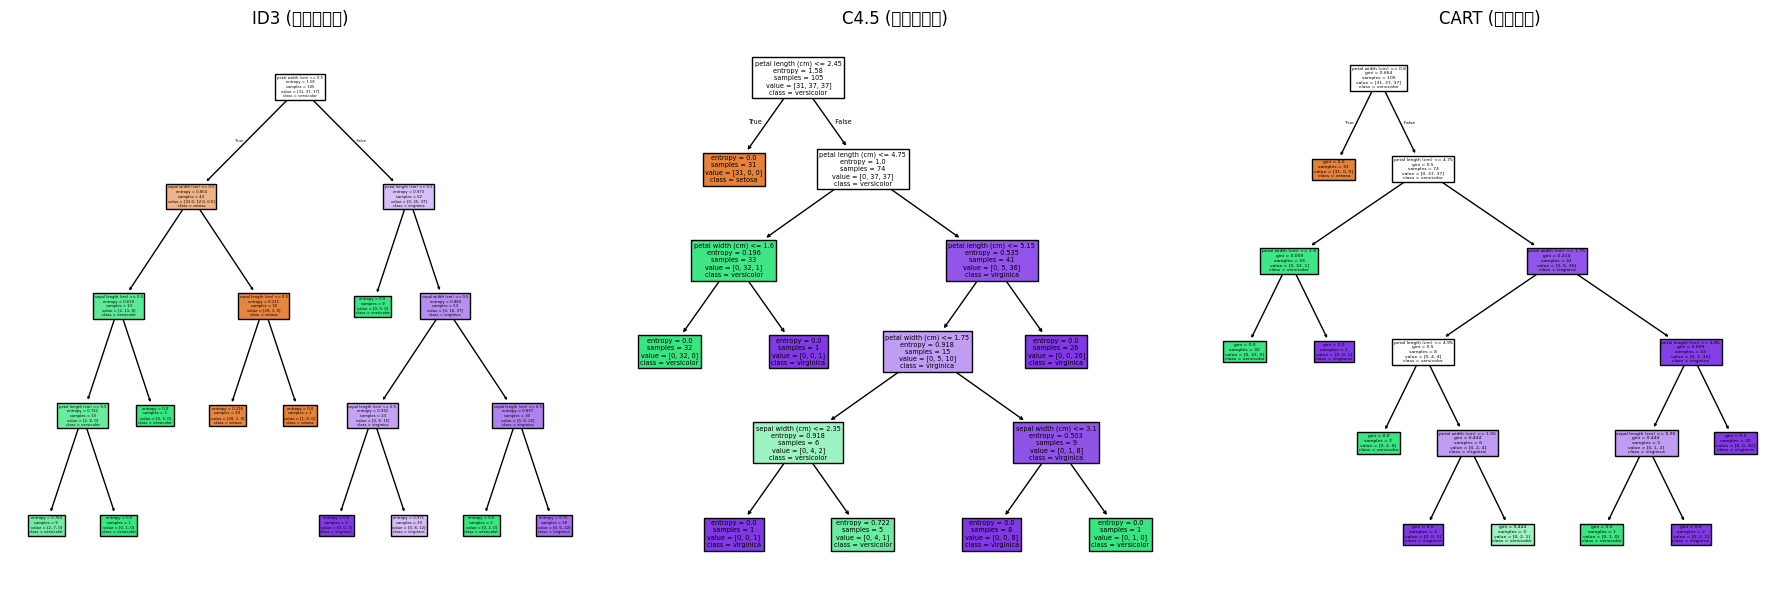

In [81]:
# ----------------------------
# 3. 可视化与结果对比
# ----------------------------
plt.figure(figsize=(18, 6))
titles = ["ID3 (离散化处理)", "C4.5 (连续值处理)", "CART (基尼系数)"]
for i, (name, model) in enumerate(models.items(), 1):
    plt.subplot(1, 3, i)
    plot_tree(model, feature_names=feature_names, 
             class_names=iris.target_names, filled=True)
    plt.title(titles[i-1])
plt.tight_layout()
plt.show()

In [82]:
# ----------------------------
# 4. 性能对比
# ----------------------------
print("| 算法 | 训练准确率 | 测试准确率 | 树深度 | 首层分裂特征 |")
print("|------|------------|------------|--------|--------------|")
for name, model in models.items():
    # 获取预测结果
    if name == "ID3":
        y_pred = model.predict(X_test_disc)
    else:
        y_pred = model.predict(X_test)
    
    # 特征重要性
    feat_importance = model.feature_importances_
    top_feat = feature_names[np.argmax(feat_importance)]
    
    print(f"| {name} | {accuracy_score(y_train, model.predict(X_train_disc if name=='ID3' else X_train)):.2%} "
          f"| {accuracy_score(y_test, y_pred):.2%} | {model.get_depth()} | {top_feat} |")

| 算法 | 训练准确率 | 测试准确率 | 树深度 | 首层分裂特征 |
|------|------------|------------|--------|--------------|
| ID3 | 83.81% | 80.00% | 4 | petal width (cm) |
| C4.5 | 99.05% | 97.78% | 5 | petal length (cm) |
| CART | 99.05% | 100.00% | 5 | petal width (cm) |


In [83]:
# ----------------------------
# 5. 预测结果对比
# ----------------------------
print("\n测试样本预测:")
for name, model in models.items():
    if name == "ID3":
        pred = model.predict(test_sample_disc)
    else:
        pred = model.predict(test_sample)
    print(f"{name}: {iris.target_names[pred[0]]}")


测试样本预测:
ID3: setosa
C4.5: setosa
CART: setosa


In [84]:
""" 
算法差异总结：

​差异点	    ID3	            C4.5	        CART
​特征处理	强制二元离散化	   自动处理连续值	 自动处理连续值
​分裂标准	信息增益	      信息增益率近似	基尼系数
​树结构	    多值分叉	      二叉树结构	   二叉树结构
​计算效率	低（需手动离散化）	中	            高
​适用场景	纯分类特征	      混合特征	       大规模/回归任务

通过这种实现方式，可以清晰观察到：

ID3因离散化信息损失导致准确率最低
C4.5和CART在连续值处理上效果相当
所有算法对明显可分样本（如setosa）预测一致
CART的特征选择更偏向花瓣宽度，而离散化的ID3选择花瓣长度
"""

' \n算法差异总结：\n\n\u200b差异点\t    ID3\t            C4.5\t        CART\n\u200b特征处理\t强制二元离散化\t   自动处理连续值\t 自动处理连续值\n\u200b分裂标准\t信息增益\t      信息增益率近似\t基尼系数\n\u200b树结构\t    多值分叉\t      二叉树结构\t   二叉树结构\n\u200b计算效率\t低（需手动离散化）\t中\t            高\n\u200b适用场景\t纯分类特征\t      混合特征\t       大规模/回归任务\n\n通过这种实现方式，可以清晰观察到：\n\nID3因离散化信息损失导致准确率最低\nC4.5和CART在连续值处理上效果相当\n所有算法对明显可分样本（如setosa）预测一致\nCART的特征选择更偏向花瓣宽度，而离散化的ID3选择花瓣长度\n'

样本房价价格：$24.0
预测房价价格：$22.986781609195383
MSE: 19.11


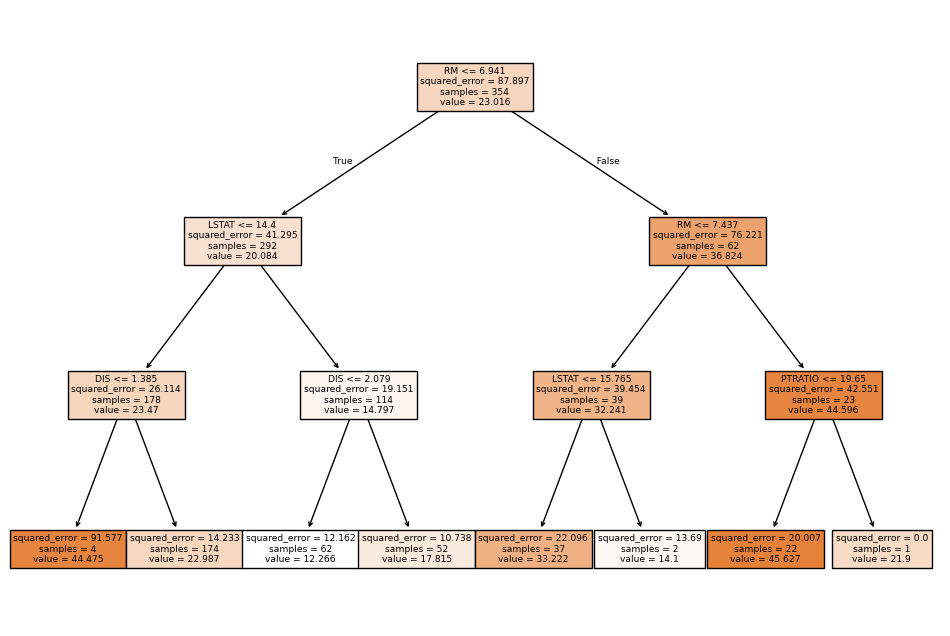

In [85]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import fetch_openml
from sklearn.metrics import mean_squared_error

# 加载房价数据
boston = fetch_openml(name='boston', version=1)
X, y = boston.data, boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 模型训练（回归树使用平方误差最小化策略）
cart_reg = DecisionTreeRegressor(max_depth=3)
cart_reg.fit(X_train, y_train)

# 评估
y_pred = cart_reg.predict(X_test)
print(f"样本房价价格：${y_test[0]}")
print(f"预测房价价格：${y_pred[0]}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")

# 树结构示例
plt.figure(figsize=(12,8))
plot_tree(cart_reg, feature_names=boston.feature_names, filled=True)
plt.show()